## 1. Introdução

Após o EDA, pudemos entender quais variaveis eram claras no impacto climático na operação, com isso, pudemos elaborar modelos que buscam compreender seus impactos.

Começamos importando o dataset do repositório, onde ja foi previamente tratado em **data-abtra-climate**, separando entre target e feature e posteriormente seus conjuntos de **treino** e **teste**.

In [ ]:
!wget https://raw.githubusercontent.com/owsei-data/abtra-climate-impact/refs/heads/main/data/final/analise_tempo_DI_clima.csv

--2025-11-23 22:46:09--  https://raw.githubusercontent.com/owsei-data/abtra-climate-impact/refs/heads/main/data/final/analise_tempo_DI_clima.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11696 (11K) [text/plain]
Saving to: ‘analise_tempo_DI_clima.csv’

analise_tempo_DI_cl 100%[===================>]  11.42K  --.-KB/s    in 0s      

2025-11-23 22:46:09 (69.4 MB/s) - ‘analise_tempo_DI_clima.csv’ saved [11696/11696]



In [ ]:
import pandas as pd

data = pd.read_csv('analise_tempo_DI_clima.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mes                         82 non-null     int64  
 1   ano                         82 non-null     int64  
 2   tipo.documento              82 non-null     int64  
 3   total.ctr                   82 non-null     int64  
 4   entrada.ate.doc.import      82 non-null     float64
 5   doc.import.ate.desembaraco  82 non-null     float64
 6   desembaraco.ate.saida       82 non-null     float64
 7   entrada.ate.saida           82 non-null     float64
 8   operador                    82 non-null     float64
 9   transito                    82 non-null     float64
 10  recinto                     82 non-null     float64
 11  porto                       82 non-null     float64
 12  descricao_doc               82 non-null     object 
 13  Ano                         82 non-nu

In [ ]:
#variaveis utilizadas

features = ['Chuva_Total', 'Vento_Max_Mes', 'Mes']
target = 'entrada.ate.saida'

In [ ]:
from sklearn.model_selection import train_test_split

df_modelo = data.dropna(subset=features + [target])

X = df_modelo[features]
y = df_modelo[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(22, 3)
(6, 3)
(22,)
(6,)


## 2. Treinamento e Avaliação do Modelo (Tempo)

Agora que os conjuntos de treino e teste estão divididos, vamos instancionar o modelo, iniciando sua busca pela equação que melhor se encaixa nas features.

Após o treino, vamos medir o desempenho usando duas métricas:
1.  **RMSE (Erro Médio):** O quanto o modelo erra em dias? (Ex: Errou por 2 dias para mais ou para menos).
2.  **R² (Score):** O quanto o modelo consegue explicar da realidade? (1.0 é perfeito, 0.0 é inútil).

In [ ]:
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

Com as métricas de RMSE e R², pudemos entender que o fit do modelo foi péssimo. Atribuímos isto a diversos pontos como: **Quantidade de dados**, como pudemos ver na separação dos dados, tivemos apenas 22 meses para treinar e 6 meses para testar, isso já influencia e muito pois basta 1 mês atípico, e ja perdemos pontos importantes.

O ponto positivo é que conseguimos mensurar, mesmo que com baixa captção dos dadddos, o impacto de cada variável na operação. Com coeficientes positivos, pudedmos perceber que:

1. **Chuva total** impacta em +0.0018
2. **Vento_Max_Mes** impacta em +0.0802
3. O **Mês** tem o impacto de 0.1148, captando alguma recorrência em certos meses.

Com isso temos a formula tempo = 12,75 + (0,0018*Chuva) + (0,08*Vento) + (0,11*Mês)

## Os custos
1. **O "Basal"**: Se o tempo fosse perfeito (sem chuva/vento) em Janeiro, o tempo padrão já seria de ~13 dias (Intercepto 12.75).

2. **O Custo do Vento**: Cada 1 m/s a mais de rajada adiciona 0.08 dias (~2 horas) no processo. Uma tempestade forte (25 m/s) adiciona sozinha **2 dias inteiros** de atraso comparada a um dia calmo.

3. **O Custo da Sazonalidade**: Do começo do ano (Mês 1) para o final (Mês 12), o atraso aumenta naturalmente em **~1.2** dias só por causa da safra (11 meses * 0.11).

4. **O Custo da Chuva**: É o menor impacto. Precisa chover muito (1000mm) para atrasar 1.8 dias. O vento é o vilão real.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 1.8593784004904492
R²: -0.2245351931914461


In [ ]:
for feature, coef in zip(features, modelo.coef_):
    print(f"{feature}: {coef:.4f}")

print(f'Intercepto: {modelo.intercept_:2f} dias')

Chuva_Total: 0.0018
Vento_Max_Mes: 0.0802
Mes: 0.1148
Intercepto: 12.751095 dias


## 3. Treinamento e Avaliação do Modelo (Carga)

Nesta etapa, o objetivo muda: não queremos mais saber *quanto tempo* demora, mas sim *quanto de carga* (Peso Líquido) conseguimos movimentar sob certas condições climáticas.

Utilizamos a Regressão Linear para tentar prever o `peso.liquido` baseando-se nas mesmas variáveis climáticas (`Chuva`, `Vento`) e sazonais (`Mês`).

**Métricas analisadas:**
* **RMSE:** O erro médio em toneladas/unidade de peso.
* **MAPE (Erro Percentual):** Para a carga, o erro absoluto importa menos que o percentual. Errar 67 toneladas em um navio de 10.000 é pouco, mas em um caminhão é muito.
* **R²:** A capacidade das variáveis climáticas explicarem a variação de volume.

In [ ]:
!wget https://raw.githubusercontent.com/owsei-data/abtra-climate-impact/refs/heads/main/data/final/analise_carga_descarregada_clima.csv

--2025-11-23 22:46:12--  https://raw.githubusercontent.com/owsei-data/abtra-climate-impact/refs/heads/main/data/final/analise_carga_descarregada_clima.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9019 (8.8K) [text/plain]
Saving to: ‘analise_carga_descarregada_clima.csv’

analise_carga_desca 100%[===================>]   8.81K  --.-KB/s    in 0s      

2025-11-23 22:46:13 (85.9 MB/s) - ‘analise_carga_descarregada_clima.csv’ saved [9019/9019]



In [ ]:
carga = pd.read_csv('analise_carga_descarregada_clima.csv')
carga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mes              82 non-null     int64  
 1   ano              82 non-null     int64  
 2   sit.carga        82 non-null     object 
 3   qtde.unidades    82 non-null     int64  
 4   qtde.teus        82 non-null     int64  
 5   peso.bruto       82 non-null     float64
 6   peso.liquido     82 non-null     float64
 7   descricao_carga  82 non-null     object 
 8   Ano              82 non-null     int64  
 9   Mes              82 non-null     int64  
 10  Chuva_Total      49 non-null     float64
 11  Chuva_Max_Dia    49 non-null     float64
 12  Vento_Max_Mes    29 non-null     float64
 13  Vento_Media      29 non-null     float64
 14  Pct_Chuva        82 non-null     float64
 15  Pct_Vento        82 non-null     float64
 16  clima_valido     82 non-null     bool   
dtypes: bool(1), float6

In [ ]:
# variaveis utilizadas

features_carga = ['Chuva_Total', 'Vento_Max_Mes', 'Mes']
target_carga = 'peso.liquido'

In [ ]:
df_carga_model = carga.dropna(subset=features_carga + [target_carga])

X_c = df_carga_model[features_carga]
y_c = df_carga_model[target_carga]

#split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

print(X_train_c.shape)
print(X_test_c.shape)
print(y_train_c.shape)
print(y_test_c.shape)

(22, 3)
(6, 3)
(22,)
(6,)


In [ ]:
#regressao

modelo_carga = LinearRegression()
modelo_carga.fit(X_train_c, y_train_c)

y_pred_c = modelo_carga.predict(X_test_c)

In [ ]:
#avalicao

rmse_c = np.sqrt(mean_squared_error(y_test_c, y_pred_c))
r2_c = r2_score(y_test_c, y_pred_c)

print(f"RMSE: {rmse_c}")
print(f"R²: {r2_c}")

RMSE: 67.03214203914601
R²: 0.19624429987092895


In [ ]:
#impacto das variaveis

for feature, coef in zip(features_carga, modelo_carga.coef_):
    print(f"{feature}: {coef:.4f}")

print(f'Intercepto: {modelo_carga.intercept_:2f} quilos') #intercepto

Chuva_Total: -0.2712
Vento_Max_Mes: 6.0955
Mes: 1.7443
Intercepto: 799.932432


In [ ]:
def calcular_acuracia_percentual(y_real, y_previsto):
    mape = np.mean(np.abs((y_real - y_previsto) / y_real)) * 100

    acuracia = 100 - mape
    return acuracia, mape

acc_carga, erro_carga = calcular_acuracia_percentual(y_test_c, y_pred_c)

print(f"Erro Médio Percentual: {erro_carga:.2f}%")
print(f"Acurácia Estimada: {acc_carga:.2f}%")

Erro Médio Percentual: 5.86%
Acurácia Estimada: 94.14%


R² Treino: 0.1639
R² Teste: 0.1962


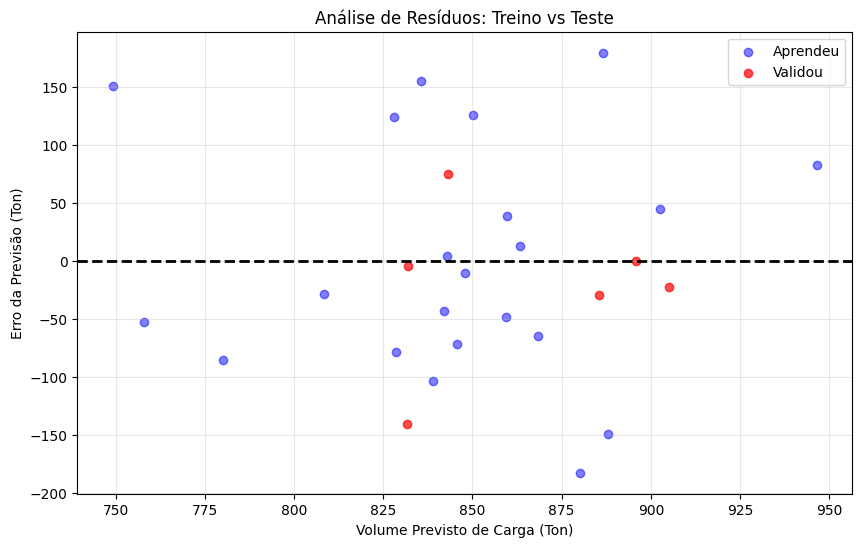

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_train = modelo_carga.predict(X_train_c)
y_pred_test = modelo_carga.predict(X_test_c)

#scores
r2_treino = r2_score(y_train_c, y_pred_train)
r2_teste = r2_score(y_test_c, y_pred_test)

print(f"R² Treino: {r2_treino:.4f}")
print(f"R² Teste: {r2_teste:.4f}")


plt.figure(figsize=(10, 6))

residuos_train = y_train_c - y_pred_train
residuos_test = y_test_c - y_pred_test

plt.scatter(y_pred_train, residuos_train, c='blue', alpha=0.5, label='Aprendeu')
plt.scatter(y_pred_test, residuos_test, c='red', alpha=0.7, label='Validou')

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.xlabel('Volume Previsto de Carga (Ton)')
plt.ylabel('Erro da Previsão (Ton)')
plt.title('Análise de Resíduos: Treino vs Teste')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Os resultados do modelo de carga mostram um cenário diferente do modelo de tempo:

1.  **Acurácia Alta (94%):** Diferente do tempo, que flutua muito, o modelo conseguiu uma acurácia estimada muito alta (~94%). Isso indica que o volume de carga é mais previsível ou constante do que os tempos de operação.
2.  **R² Baixo (0.19):** Embora o erro seja baixo, o $R^2$ baixo indica que **o clima não é o principal fator que define a quantidade de carga**. A demanda de mercado e o tamanho dos navios influenciam muito mais o volume do que a chuva ou o vento.

#### O Impacto Climático no Volume (Coeficientes)

A equação descoberta foi: `Carga = 799.9 - (0.27 * Chuva) + (6.09 * Vento) + (1.74 * Mês)`

1.  **O "Basal" (Intercepto):** Em condições normais, a operação movimenta uma média base de **~800 toneladas** (ou a unidade de medida correspondente aos dados).
2.  **O Impacto da Chuva (Negativo):** Aqui a física opera. O coeficiente é **-0.27**. Para cada mm de chuva, deixamos de movimentar quase 300kg (ou 0.27 tons). A chuva impacta diretamente a produtividade, pausando guindastes ou operações de granel sensíveis à umidade.
3.  **O Impacto do Vento (Positivo?):** Curiosamente, o vento apresentou uma correlação positiva (+6.09). Isso sugere que meses de ventos mais fortes coincidem com meses de alta safra, e não que o vento "ajuda" a operação.
    * **Nota sobre o Fator Humano:** Vale ressaltar que, mesmo não afetando diretamente o volume final produzido, o aumento dos ventos gera um **desgaste físico e mental maior nos trabalhadores** responsáveis pelas movimentações (estiva e capatazia). O esforço para manter a segurança e a estabilidade da carga sob ventania é um "custo invisível" que o modelo numérico não captou, mas que impacta a equipe.

## 4. Conclusão Geral

Chegamos a duas conclusões distintas para **Tempo** e **Carga**:

### 1. O Vento é o inimigo do Tempo (Eficiência)
No primeiro modelo, descobrimos que o **Vento** é o maior vilão dos atrasos. Enquanto a chuva tem pouco impacto no tempo total de trânsito, rajadas de vento fortes podem adicionar dias à operação (coeficiente de +0.08 dias por m/s de vento).
* **Ação Sugerida:** Monitoramento preditivo de rajadas de vento para reprogramação de janelas de atracação.

### 2. A Chuva é inimiga do Volume (Produtividade)
No segundo modelo, vimos que a **Chuva** tem um coeficiente negativo sobre o peso líquido movimentado. Embora o volume total seja estável (alta acurácia do modelo), a chuva "roi" a produtividade marginal.
* **Ação Sugerida:** Para cargas sensíveis à umidade, a previsão de chuva deve gatilhar protocolos de proteção mais rápidos para evitar paradas longas.

### Resumo Técnico
Embora os modelos de Regressão Linear simples tenham apresentado $R^2$ baixo (explicando cerca de 20% da variância), eles foram fundamentais para isolar o **peso (coeficiente)** de cada variável. O clima não dita a operação inteira, mas é um "taxímetro" que cobra custos adicionais em tempo e volume.
